# Computer Vision 
## Homework 2: Creating a 3D Stereo Image from Two Images Without Camera Intrinsic Parameters

Erin Akinjide

### Step 1: Detect and Match Feature Points 

- Use feature detectors such as SIFT, ORB, or Harris Corner Detector. 
- Find corresponding points between the two images using descriptor matching. 


Visualize the location and scale of the thirty strongest features in image1 and image 2.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy
from mpl_stereo import AxesAnaglyph


Load images and convert to grayscale

In [2]:
img1_color = cv2.cvtColor(cv2.imread('000006-color.jpg'), cv2.COLOR_BGR2RGB)
img2_color = cv2.cvtColor(cv2.imread('000007-color.jpg'), cv2.COLOR_BGR2RGB)

# Load grayscale images
img1 = cv2.imread('000006-color.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('000007-color.jpg', cv2.IMREAD_GRAYSCALE)




Specify bounding box coordinates for finding the relevant keypoints

In [3]:
# --- Manually define bounding box (xmin, ymin, xmax, ymax) in pixels ---
bbox_img1 = (200, 50, 400, 400)  
bbox_img2 = (200, 0, 420, 400)  

def filter_keypoints_in_bbox(keypoints, bbox):
    """Filter keypoints to only those within the specified bounding box.
    Args:
        keypoints: List of keypoints to filter.
        bbox: Bounding box defined as (x_min, y_min, x_max, y_max).
    Returns:
        List of keypoints that fall within the bounding box.
    """
    x_min, y_min, x_max, y_max = bbox
    filtered = []
    for kp in keypoints:
        x, y = kp.pt
        if x_min <= x <= x_max and y_min <= y <= y_max:
            filtered.append(kp)
    return filtered

Use Scale Space Extrema Detection (SIFT)

In [4]:
# SIFT 
sift = cv2.SIFT_create(nfeatures=500)

# Detect keypoints and compute descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Apply bounding box filtering to extract keypoints on Cheez-it boxes
kp1_filtered = filter_keypoints_in_bbox(kp1, bbox_img1)
kp2_filtered = filter_keypoints_in_bbox(kp2, bbox_img2)

def extract_descriptors_for_keypoints(selected_kps, all_kps, all_desc):
    """Extract descriptors for the selected keypoints from the full set of keypoints and descriptors.
    Args:
        selected_kps: List of keypoints that are within the bounding box.
        all_kps: List of all keypoints detected in the image.
        all_desc: Corresponding descriptors for all keypoints.
    Returns:
        A numpy array of descriptors for the selected keypoints."""
    selected_desc = []
    for kp in selected_kps:
        idx = all_kps.index(kp)
        selected_desc.append(all_desc[idx])
    return np.array(selected_desc)

des1_filtered = extract_descriptors_for_keypoints(kp1_filtered, kp1, des1)
des2_filtered = extract_descriptors_for_keypoints(kp2_filtered, kp2, des2)

Algorithm for FLANN based matcher is from OpenCV's FLANN (Fast Library for Approximate Nearest Neighbors) module.

In [5]:
#-- Step 2: Matching descriptor vectors with a FLANN based matcher
matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
knn_matches = matcher.knnMatch(des1_filtered, des2_filtered, 2)

In [6]:
#-- Filter matches using the Lowe's ratio test
ratio_thresh = 0.7
good_matches = []
for m,n in knn_matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

In [7]:
#-- Draw matches
img_matches = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
matched_img = matched_img = cv2.drawMatches(img1_color, kp1_filtered, img2_color, kp2_filtered, good_matches, None, flags=2)

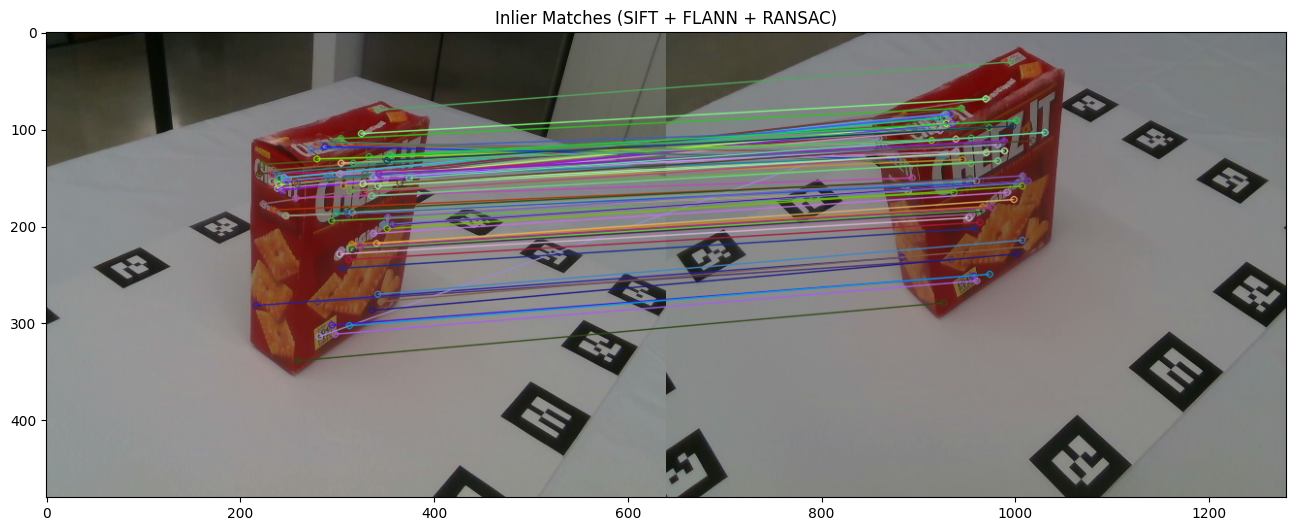

In [8]:
# Visualize the matches within the bounding boxes

plt.figure(figsize=(16, 8))
plt.imshow(matched_img)
plt.title('Inlier Matches (SIFT + FLANN + RANSAC)')
plt.axis('on')
plt.show()


Now Visualize the location and scale of the thirty strongest features in image1 and image 2.

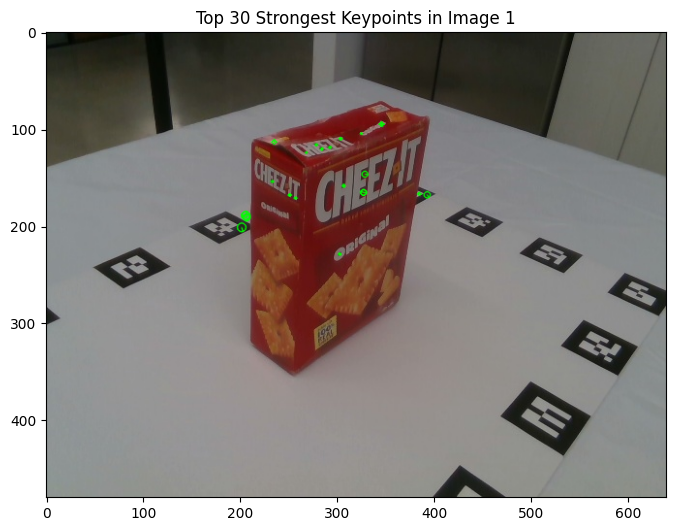

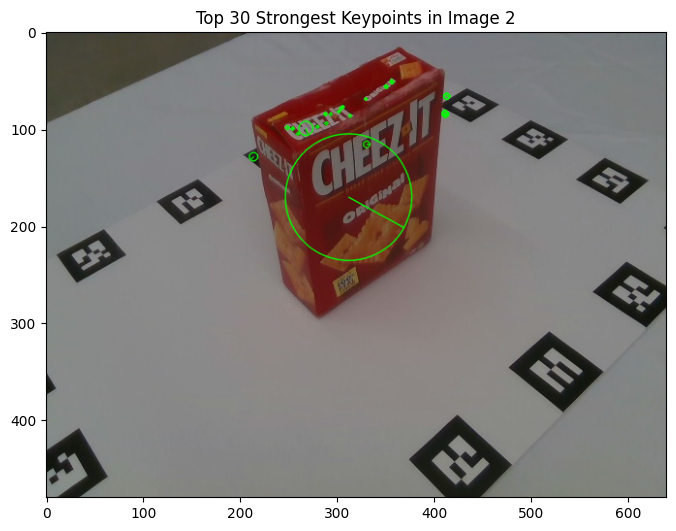

In [9]:
def draw_strongest_keypoints(image, keypoints, top_k=30, title=''):
    """    Draw the strongest keypoints on the image.
    Args:
        image: The input image.
        keypoints: The keypoints to draw.
        top_k: The number of strongest keypoints to draw.
        title: The title for the plot.
    """
    # Sort keypoints by response (strength)
    strongest_kps = sorted(keypoints, key=lambda x: -x.response)[:top_k]

    # Draw the strongest keypoints with scale
    image_with_kps = cv2.drawKeypoints(
        image,
        strongest_kps,
        outImage=None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        color=(0, 255, 0)
    )

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_kps)
    plt.title(title)
    plt.axis('on')
    plt.show()

# Visualize strongest features in both filtered images
draw_strongest_keypoints(img1_color, kp1_filtered, top_k=30, title='Top 30 Strongest Keypoints in Image 1')
draw_strongest_keypoints(img2_color, kp2_filtered, top_k=30, title='Top 30 Strongest Keypoints in Image 2')


### Step 2: Compute the Fundamental Matrix FF

- Estimate the Fundamental Matrix FF using RANSAC to remove outliers.

Fundamental Matrix (F):
 [[ 1.77648063e-05 -5.58428437e-05 -1.41195087e-02]
 [ 6.53949936e-05 -3.03275519e-06 -3.70622072e-02]
 [ 2.95845162e-03  3.62126779e-02  1.00000000e+00]]


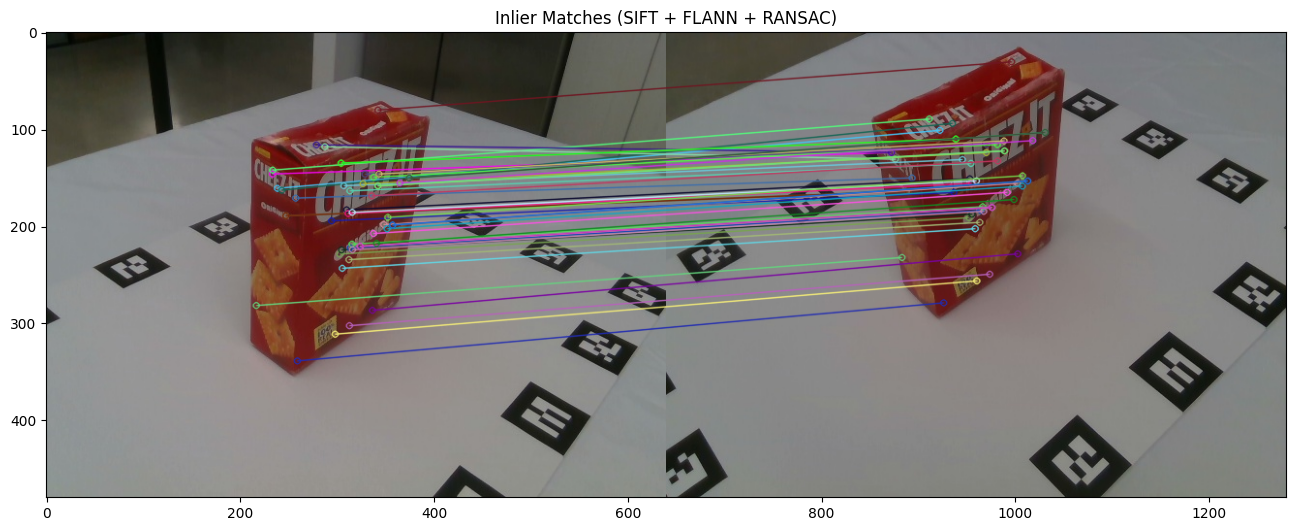

In [10]:
# Extract matched keypoint coordinates from filtered keypoints
pts1 = np.float32([kp1_filtered[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2_filtered[m.trainIdx].pt for m in good_matches])

# Compute the Fundamental Matrix using RANSAC
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0, confidence=0.99)

# Filter inlier matches using the mask
inlier_matches = [good_matches[i] for i in range(len(good_matches)) if mask[i]]

# Print fundamental matrix
print("Fundamental Matrix (F):\n", F)

# Only draw inlier matches
inlier_matched_img = cv2.drawMatches(
    img1_color, kp1_filtered, img2_color, kp2_filtered, inlier_matches, None,
    flags=2
)

plt.figure(figsize=(16, 8))
plt.imshow(inlier_matched_img)
plt.title("Inlier Matches (SIFT + FLANN + RANSAC)")
plt.axis('on')
plt.show()


### Step 3: Draw Epipolar Lines

Sample 3 pixels from image 1 to draw epipolar lines in image 2.

In [11]:
# Sample 3 pixels from image 1 (x, y)
sample_pts_img1 = np.float32([
    [250, 150],  # point 1
    [300, 250],  # point 2
    [350, 100]   # point 3
])

# Convert to shape (N, 1, 2) for cv2.computeCorrespondEpilines
sample_pts_img1_reshaped = sample_pts_img1.reshape(-1, 1, 2)


In [12]:
# Each line is returned as [a, b, c] corresponding to ax + by + c = 0
epilines_img2 = cv2.computeCorrespondEpilines(sample_pts_img1_reshaped, 1, F)
epilines_img2 = epilines_img2.reshape(-1, 3)


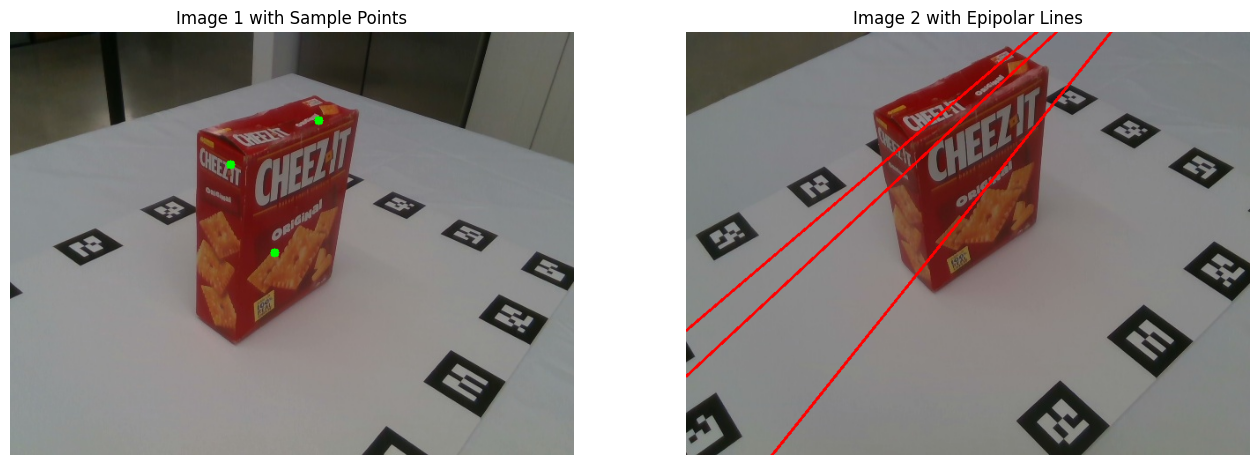

In [13]:
# Make a copy to draw lines
img2_with_lines = img2_color.copy()

# Image width for drawing lines across full image
cols = img2_with_lines.shape[1]

for r in epilines_img2:
    a, b, c = r
    # Compute two points on the line: (x=0 and x=cols)
    x0, y0 = 0, int(-c / b)
    x1, y1 = cols, int(-(a * cols + c) / b)
    img2_with_lines = cv2.line(img2_with_lines, (x0, y0), (x1, y1), (255, 0, 0), 2)

# Show sample points in image 1 too
img1_with_points = img1_color.copy()
for pt in sample_pts_img1:
    img1_with_points = cv2.circle(img1_with_points, tuple(int(x) for x in pt), 5, (0, 255, 0), -1)

# Plot both images
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1_with_points)
plt.title("Image 1 with Sample Points")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_with_lines)
plt.title("Image 2 with Epipolar Lines")
plt.axis('off')
plt.show()


### Step 4: Rectify the Images

#### 4.1
Use cv2.stereoRectifyUncalibrated to compute rectification homographies H1 and H2.

In [14]:
# pts1 and pts2 should be defined from good_matches and the mask is from 
# previous steps cv2.findFundamentalMat (inliers = 1)

inlier_pts1 = pts1[mask.ravel() == 1]
inlier_pts2 = pts2[mask.ravel() == 1]


In [15]:
# Confirm image sizes match 
img1.shape, img2.shape

# Get image dimensions
h, w = img1.shape

# Compute homographies for image 1 and 2
rect_val, H1, H2 = cv2.stereoRectifyUncalibrated(inlier_pts1, inlier_pts2, F, (w, h))

if not rect_val:
    raise Exception("Stereo rectification failed.")

#### 4.2
Apply the homographies

In [16]:
# Warp both color images
img1_rectified = cv2.warpPerspective(img1_color, H1, (w, h))
img2_rectified = cv2.warpPerspective(img2_color, H2, (w, h))


Visualize the rectified images

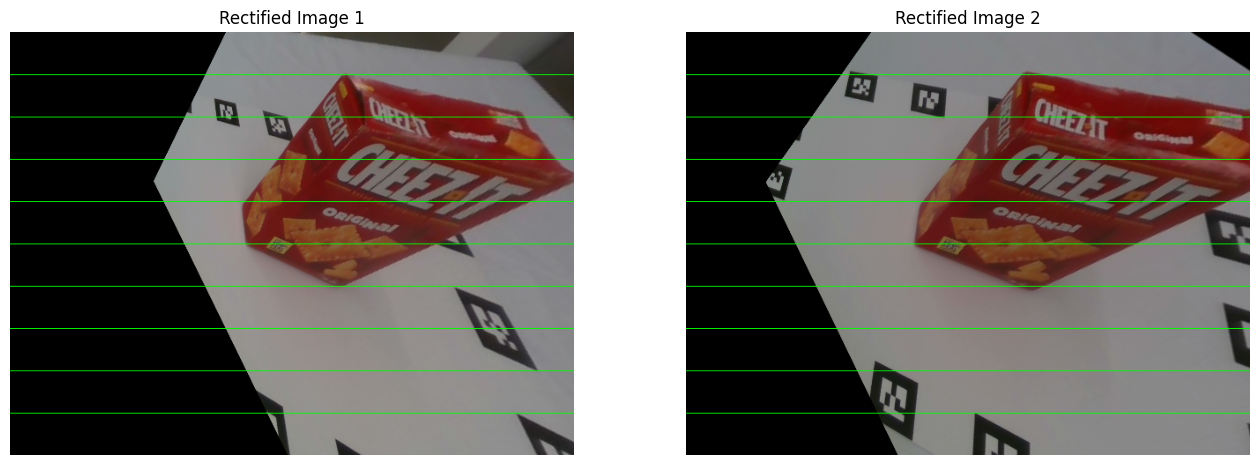

In [17]:
def draw_horizontal_lines(img, num_lines=10, color=(0, 255, 0)):
    """ Draw horizontal lines across the image at equal intervals.
    Args:        img: The input image.
        num_lines: Number of horizontal lines to draw.
        color: Color of the lines in BGR format.
    Returns:
        Image with horizontal lines drawn."""
    h, w, _ = img.shape
    interval = h // num_lines
    img_out = img.copy()
    for i in range(1, num_lines):
        y = i * interval
        cv2.line(img_out, (0, y), (w, y), color, 1)
    return img_out

# Draw lines for visualization
img1_lines = draw_horizontal_lines(img1_rectified)
img2_lines = draw_horizontal_lines(img2_rectified)

# Plot the images side-by-side
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1_lines)
plt.title("Rectified Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2_lines)
plt.title("Rectified Image 2")
plt.axis('off')
plt.show()


As provided in the assignment intructions, rectification transforms both images so that the corresponding points lie on the same row.

Rectification helps with the stereo matching process by simplifying stereo matching to a 1D search along the epipolar lines.

A stereo anaglph is a composite image where the left view is mapped to the red channel and the right view is mapped to the green and blue channels.

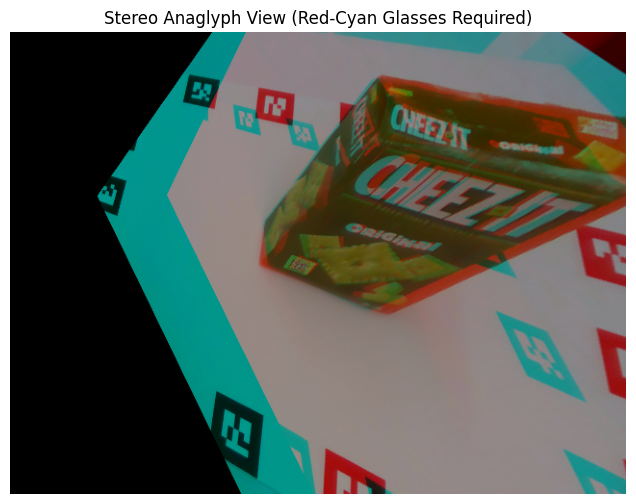

In [21]:
# Make sure both images are same shape and RGB
assert img1_rectified.shape == img2_rectified.shape

# Display with AxesAnaglyph
fig = plt.figure(figsize=(10, 6))
ax = AxesAnaglyph(fig)
ax.imshow_stereo(img1_rectified, img2_rectified)
ax.set_title("Stereo Anaglyph View (Red-Cyan Glasses Required)")
plt.axis("off")
plt.show()



As seen in the figure above the alignment of the images is not perfect, but they are relatively close.